Plan

- Make a pipeline to get the data in to a sql database
- Subset to just the bills introduced in the senate
    - Actions up to the first third reading
- Create the following features
    - Madigan or not
    - chief sponsor
    - number of co sponsors
    - committee it was in
    - perhaps how long something took (intro to second reading)
    - first word in description
    - 

# Put Data In DB

In [341]:
import pandas as pd
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
from sklearn.preprocessing import StandardScaler
import re
from bs4 import BeautifulSoup
import requests
import time

pd.set_option('display.max_rows', 80)

In [2]:
bills = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills.csv')

In [3]:
bills = bills.rename(columns={ 'bill_id': 'session_id', 'session_id': 'bill_number', 'bill_number': 'bill_id' })

In [4]:
bills.to_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills_renamed.csv')

In [5]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost:5432/ill_leg', echo=False)

In [ ]:
# bills.to_sql('bill', con=engine)

In [ ]:
# history = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/history.csv')
# people = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/people.csv')
# roll_calls = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/rollcalls.csv')
# sponsors = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/sponsors.csv')
# votes = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/votes.csv')

In [ ]:
# for name, df in zip(['history', 'people', 'roll_call', 'sponsor', 'vote'],[history, people, roll_calls, sponsors, votes]):
#     df.to_sql(name, con=engine)

# Fetch Data

In [ ]:
# Limit to just bills from this year that started in the Senate and got to a second reading
query_bills = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    )
    select * from bill
    where bill_id in (
        select * from started_senate
    ) and bill_id in (
        select * from had_sec_read
    );
"""

bills = pd.read_sql(query_bills, con=engine)

In [ ]:
bills = bills.drop(columns=['index'])

# Remove Trivial Resolutions

In [ ]:
bills = bills[~bills.last_action.str.contains('Resolution Adopted')]

In [ ]:
bills.status_desc.value_counts()

In [ ]:
526 / (526 + 1194)
# Passing percentage of non-resolution bills that get a second reading

# Explore Failures

In [ ]:
bills[bills.status_desc == 'Failed'].last_action.value_counts()
# evertything dies or is vetoed by gov (for the most part)
# only 8 things lost a senate vote (and one of those passed)
# vetoed is also a status (seems inconsistent - perhaps vetoed mean line item veto'd?)
# most of the hanging "introduced" bills had failed votes (4 introduced, 2 engrossed)

In [ ]:
bills.status_desc.value_counts()

In [135]:
def clean_bills(df):
    df = df[~df.last_action.str.contains('Resolution Adopted')].drop_duplicates(subset=['bill_id'])
    df.third_reading_id = df.third_reading_id.map(lambda x: 1 if x else 0)
    df.sponsor_count = df.sponsor_count.fillna(0)
    return df

# Get Ideology Data

In [13]:
ideology = pd.read_stata('./data/shor+mccarty+1993-2016+individual+legislator+data+May+2018+release+(Updated+July+2018).dta')

In [17]:
sen_ideol = ideology[[
    'name',
    'party',
    'st',
    'st_id',
    'np_score',
    'senate2015',
    'senate2016',
    'sdistrict2015',
    'sdistrict2016'
]]

In [22]:
ill_sen_ideol = sen_ideol[sen_ideol.st == 'IL'].dropna(subset=['senate2015', 'senate2016', 'sdistrict2015', 'sdistrict2016'], how='all')

In [37]:
ill_sen_ideol = ill_sen_ideol.replace(to_replace='', value=np.nan)

In [40]:
query_senators = """
    select * from people p
    where role = 'Sen'
"""

people = pd.read_sql(query_senators, con=engine)

In [55]:
ill_sen_ideol['first_last'] = ill_sen_ideol.name.map(lambda x: x.split(', ')[1] + ' ' + x.split(', ')[0])

In [108]:
def find_best_sen_match(first_last):
    sim_scores = people.name.map(lambda x: fuzz.token_set_ratio(x, first_last))
    if sim_scores.max() < 80:
        return np.nan
    return people.loc[sim_scores.idxmax(), 'people_id']

In [109]:
ill_sen_ideol['people_id'] = ill_sen_ideol.first_last.map(find_best_sen_match)

In [118]:
ill_sen_ideol.people_id = ill_sen_ideol.people_id.astype('Int32')

In [119]:
ill_sen_ideol.loc[ill_sen_ideol.first_last == 'Patricia Van Pelt', 'people_id'] = 14324
ill_sen_ideol.loc[ill_sen_ideol.first_last == 'William Jr. Brady', 'people_id'] = 1052

In [ ]:
# ill_sen_ideol.to_sql('ideology', con=engine)

# Number of Co-sponsors at Second Reading

In [136]:
query_sponsors_at_second = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    ), num_sponsors_at_sec as (
    	select b.bill_id, count(h.action) as sponsor_count
    	from bill b
    	join history hs on hs.bill_id = b.bill_id and hs.action ~* '^second reading'
    	join history h on h.bill_id = b.bill_id
    	where h.action ~* 'sponsor' and h.action ~* 'added' and h.sequence < hs.sequence
    	group by b.bill_id
    )
    select b.*, n.sponsor_count, case when h.index > 0 then true else false end as third_reading_id from bill b
    left join num_sponsors_at_sec n on n.bill_id = b.bill_id
    left join history h on h.bill_id = b.bill_id and h.action ~* 'third reading' and (h.action ~* 'passed' or h.action ~* 'lost')
    where b.bill_id in (
        select * from started_senate
    ) and b.bill_id in (
        select * from had_sec_read
    );
"""

bill_spons_sec = pd.read_sql(query_sponsors_at_second, con=engine)

In [137]:
bill_spons_sec = clean_bills(bill_spons_sec)

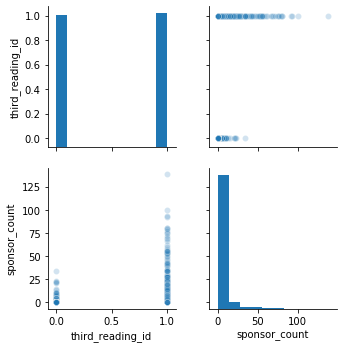

In [138]:
sns.pairplot(bill_spons_sec[['third_reading_id', 'sponsor_count']], plot_kws={ 'alpha': 0.2})

In [168]:
bill_spons_sec[bill_spons_sec.sponsor_count == 0].third_reading_id.value_counts()

0    793
1    328
Name: third_reading_id, dtype: int64

In [169]:
bill_spons_sec.sponsor_count.sum()

6538.0

# Ideology of Author

In [147]:
query_bill_author = """
    select b.bill_id, a.people_id, i.*, b.third_reading
    from sen_bill b
    left join author a on a.bill_id = b.bill_id
    left join ideology i on a.people_id = i.people_id
"""

author = pd.read_sql(query_bill_author, con=engine)
# 47 second query -> improve

In [164]:
std = StandardScaler()
author['scaled_np_score'] = np.abs(author.np_score - author.np_score.mean())

In [165]:
author.scaled_np_score.describe()

count    1468.000000
mean        0.520628
std         0.262165
min         0.006412
25%         0.458412
50%         0.491412
75%         0.695588
max         1.241588
Name: scaled_np_score, dtype: float64

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


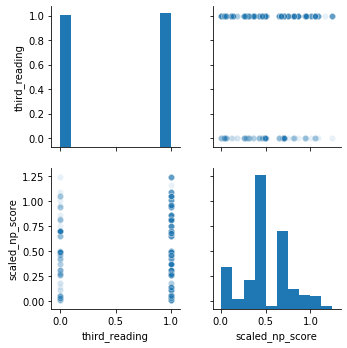

In [166]:
sns.pairplot(author[['third_reading', 'scaled_np_score']], plot_kws={ 'alpha': 0.1})

# Ideology Range of Sponsors at 2nd Reading

In [173]:
query_range = """
select b.bill_id, min(i.np_score) as min_score, max(i.np_score) as max_score, b.third_reading
from sen_bill b
left join sponsor_at_second s on b.bill_id = s.bill_id
left join ideology i on i.people_id = s.people_id
group by b.bill_id, b.third_reading
"""

ideol_range = pd.read_sql(query_range, con=engine)

In [174]:
ideol_range['ideol_range'] = np.abs(ideol_range.max_score - ideol_range.min_score)
ideol_range.ideol_range = ideol_range.ideol_range.fillna(0)

In [175]:
ideol_range.head()

,bill_id,min_score,max_score,third_reading,ideol_range
0,1087131,NaN,NaN,1,0.000
1,1087344,NaN,NaN,0,0.000
2,1074782,0.431,0.655,1,0.224
3,1089962,-1.241,-0.436,0,0.805
4,1084143,NaN,NaN,1,0.000


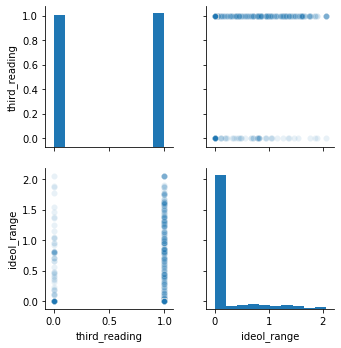

In [177]:
sns.pairplot(ideol_range[['third_reading', 'ideol_range']], plot_kws={ 'alpha': 0.1})

# Get Hearing Data

In [178]:
url = 'http://www.ilga.gov/legislation/witnessslip.asp?DocNum=3&DocTypeID=SB&LegID=98846&GAID=14&SessionID=91&GA=100&SpecSess='

In [344]:
def scrape_slips(url):
    dfs = pd.read_html(url, attrs={ 'width': '100%', 'cellpadding': '3'}, header=0)
    hearing = dfs[0]
    if len(hearing) == 1:
        return pd.DataFrame(columns=['name', 'firm_business_or_agency', 'representing'])
    hearing['date'] = hearing.Name.map(lambda x: x if 'Hearing Date and Time' in x else np.nan)
    hearing.date = hearing.date.fillna(method='ffill')
    hearing = hearing.loc[~hearing.Name.str.contains('Hearing Date and Time')]
    hearing['bill_number'] = 'SB-0003'
    hearing.date = hearing.date.map(lambda x: pd.to_datetime(re.compile('\d{1,2}\/\d{1,2}\/\d{4}').search(x)[0]))
    hearing.columns = [x.lower().replace(' ', '_').replace(',', '') for x in hearing.columns]
    return hearing

In [345]:
def scrape_all_positions(url):
    frames = []
    for pos in ['PROP', 'OPP', 'NOPOS']:
        frames.append(scrape_slips(url + '&WSType=' + pos))
    return pd.concat(frames)

In [346]:
def scrape_totals(url):
    dfs = pd.read_html(url, attrs={ 'width': '600', 'bordercolor': 'white'})
    hearing_totals = dfs[0]
    col_names = ['proponents', 'opponents', 'no_position']
    hearing_totals.columns = col_names + ['na']
    hearing_totals = hearing_totals.dropna(how='all')[col_names]
    for col in ['proponents', 'opponents', 'no_position']:
        hearing_totals[col] = hearing_totals[col].map(lambda x: x.split(': ')[1]).astype('int')
    return hearing_totals

In [347]:
def scrape_100():
    all_sen_bills_url = 'http://www.ilga.gov/legislation/grplist.asp?num1=1&num2=3649&DocTypeID=SB&GA=100&SessionId=91'
    res = requests.get(all_sen_bills_url)
    bs = BeautifulSoup(res.text)
    hearing_frames = []
    witness_slip_frames = []
    for a in bs.find('ul').find_all('a'):
        time.sleep(1)
        hearing_url = 'http://www.ilga.gov{url}'.format(url = a.get('href')).replace('BillStatus', 'witnessslip')
        bill_number = re.compile('SB\d{4}').search(a.text)[0]

        new_hearing = scrape_totals(hearing_url)
        new_hearing['bill_number'] = bill_number
        hearing_frames.append(new_hearing)
        
        new_witness = scrape_all_positions(hearing_url)
        new_witness['bill_number'] = bill_number
        witness_slip_frames.append(new_witness)
        
    return pd.concat(hearing_frames), pd.concat(witness_slip_frames)

In [348]:
hearing, slips = scrape_100()

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas

KeyboardInterrupt: 

In [305]:
hearing.to_sql('hearing', con=engine)

,proponents,opponents,no_position,bill_number
0,326,204,7,SB0001
0,4,46,0,SB0002
0,58,7,2,SB0003
0,14,3,1,SB0004
0,6,5,0,SB0005


In [ ]:
slips = slips.